In [1]:
#Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')
import time
import yfinance as yf

We are going to create two portfolios. The first portfolio will contain ETFs corresponding to differnt sectors. We will add Industrial Select Sector SPDR Fund(XLI), iShares U.S. Utilities ETF (IDU), The Consumer Staples Select Sector SPDR Fund (XLP), and iShares U.S. Financials ETF (IYF) in the first portfolio. The idea is to make the volitility of the portfolio as small as we can. By combining these four ETFs, we wanto to create a portfolio with a mechanism for navigating different phases of the economic cycle. During economic expansions, the cyclical components (XLI and IYF) are likely to outperform, capturing the upside of a growing economy. Conversely, during economic contractions or periods of uncertainty, the defensive holdings (IDU and XLP) can help to mitigate losses and provide a steadying influence.

In [2]:
#load data for ETF data
tickers = ["XLI", "IDU", "XLP", "IYF"]

start_date = dt.datetime.today() - dt.timedelta(days = 5*(365)) # ETF data for last 5 Years
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)
stock.head()

/tmp/ipython-input-2-2085679096.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start = start_date, end = end_date)
[*********************100%***********************]  4 of 4 completed


Price           Close                                        High             \
Ticker            IDU        IYF        XLI        XLP        IDU        IYF   
Date                                                                           
2020-06-29  61.396862  50.088749  63.250324  51.071568  61.396862  50.231753   
2020-06-30  61.665173  50.808384  63.611435  51.448837  61.898286  51.048266   
2020-07-01  63.033058  50.748421  63.324409  51.492706  63.270574  51.269697   
2020-07-02  63.143013  50.794544  63.870712  51.755913  63.741192  51.920135   
2020-07-06  62.426090  51.463448  64.787384  52.010361  63.736810  51.957046   

Price                                   Low                                   \
Ticker            XLI        XLP        IDU        IYF        XLI        XLP   
Date                                                                           
2020-06-29  63.250324  51.168079  60.050962  49.465985  61.750321  50.404770   
2020-06-30  63.972547  51.641859  61.036209  49.964191  62.583651  51.001381   
2020-07-01  64.759605  51.817335  61.581594  50.526992  63.268856  51.466386   
2020-07-02  64.815159  52.264784  62.989074  50.702284  63.713299  51.650626   
2020-07-06  65.129974  52.273574  61.937877  51.311219  64.315157  51.720831   

Price            Open                                   Volume          \
Ticker            IDU        IYF        XLI        XLP     IDU     IYF   
Date                                                                     
2020-06-29  60.574369  49.871934  62.148472  50.448637   67600  437800   
2020-06-30  61.278120  49.964191  62.768842  51.080344   59200  303600   
2020-07-01  61.581594  51.029818  64.241079  51.545350  339200  328800   
2020-07-02  63.591649  51.809419  64.342932  51.922611   68000  404200   
2020-07-06  63.336556  51.763298  64.861460  52.150739   57600  333000   

Price                           
Ticker           XLI       XLP  
Date                            
2020-06-29  10864700   9654200  
2020-06-30   8868500   7379800  
2020-07-01   9789000   7261600  
2020-07-02   8279800   6857200  
2020-07-06  10815400  10091300

We choose the data for last $5$ years because in this time we have seen a small period of economic recession and growth in the economy. So this period of time can be a good example to test the growth of the portfolio in this phase.

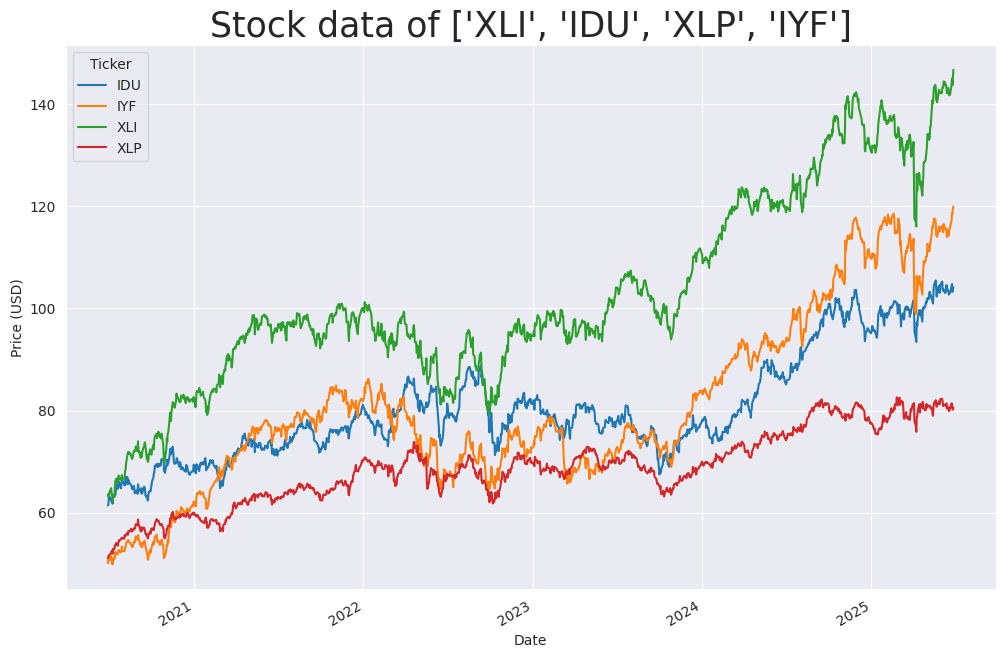

In [3]:
#Plot Closing Price of portfolio data
stock['Close'].plot(figsize = (12,8))
plt.title(f'Stock data of {tickers}', size = 25)
plt.ylabel('Price (USD)')
plt.show()

In [4]:
#Compute cumulative return from 'Close' prices
close = stock['Close']
normalized_returns = close/close.iloc[0]-1 #Moves stock prices to a start of 0


# Create columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

#Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )

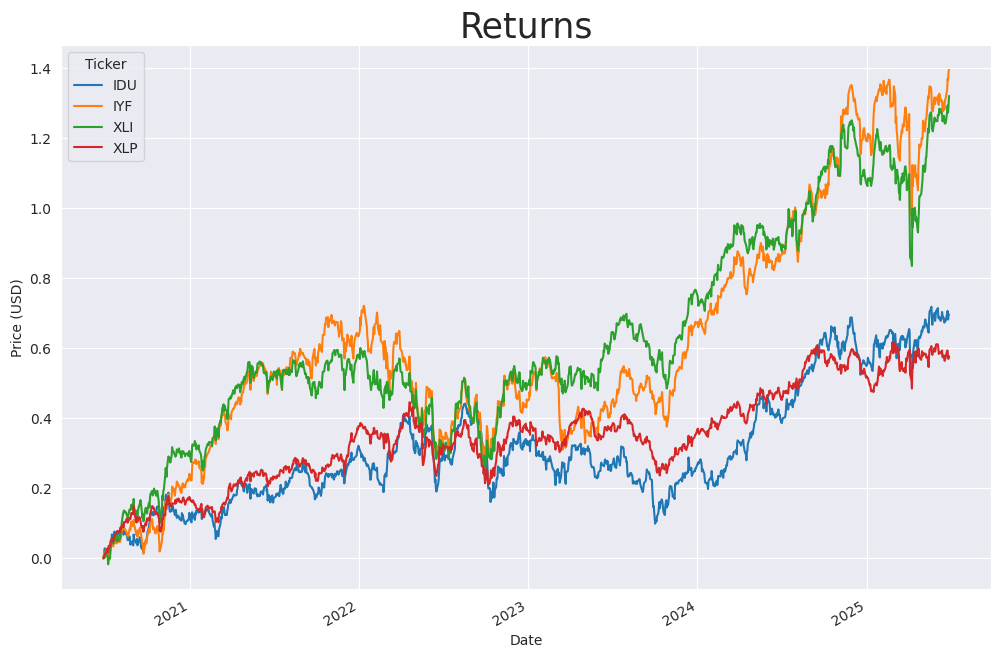

In [5]:
#Plot Cumlative Returns together
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()


In [6]:
print('Typical method of finding volatility is to find the (log) daily returns take standard deviation and then multiply by sqrt(252) to give the yearly volatility.')

Typical method of finding volatility is to find the (log) daily returns take standard deviation and then multiply by sqrt(252) to give the yearly volatility.


In [7]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()



#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}


In [8]:
annualized_volatility

{'XLI': np.float64(0.17932937223001139),
 'IDU': np.float64(0.16972984927778376),
 'XLP': np.float64(0.13210690505932762),
 'IYF': np.float64(0.19641340366682236)}

In [9]:
# Calculate the covariance matrix
covariance_matrix = 252*((daily_returns).cov())

In [10]:
covariance_matrix

Ticker,IDU,IYF,XLI,XLP
Ticker,,,,
IDU,0.028831,0.017006,0.016626,0.014660
IYF,0.017006,0.038609,0.030446,0.014192
XLI,0.016626,0.030446,0.032185,0.013892
XLP,0.014660,0.014192,0.013892,0.017466


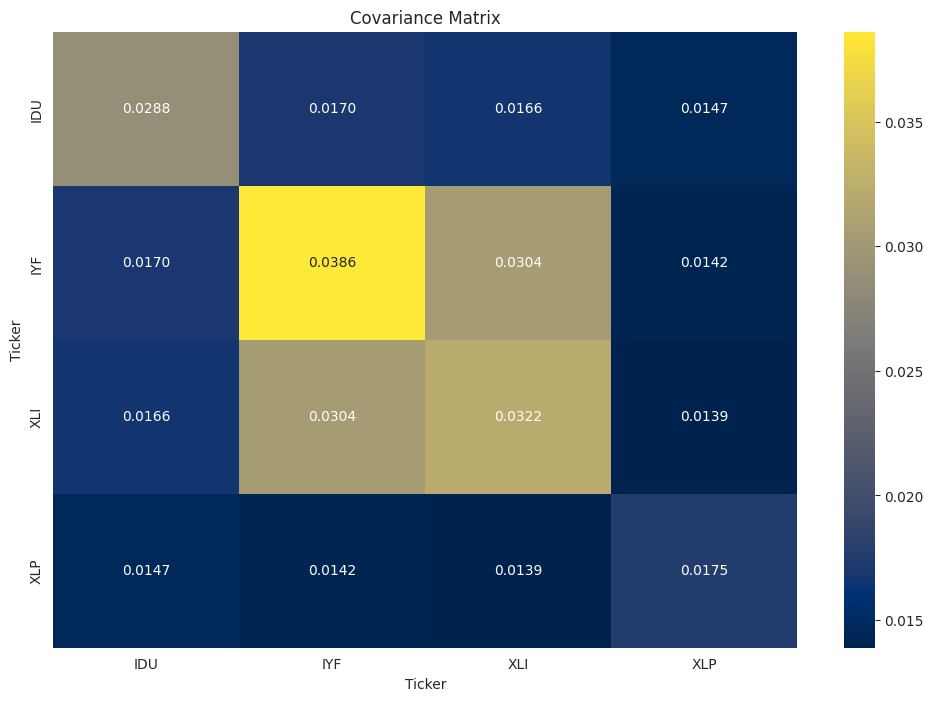

In [11]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

In [12]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols,
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Must invest at least 10% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
#expected_returns = {stock: 252*np.mean(returns[stock]) for stock in stock_symbols}


# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1
#Allocate at least 3% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.1},
              {'type': 'ineq', 'fun': lambda weights: .40-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility:
XLI: Weight = 0.3171
IDU: Weight = 0.1000
XLP: Weight = 0.1829
IYF: Weight = 0.4000


In [13]:
print(f' The optimal volatility subject to the constraints is {result.fun}')

 The optimal volatility subject to the constraints is 0.1347741063806598


In [14]:
annualized_volatility

{'XLI': np.float64(0.17932937223001139),
 'IDU': np.float64(0.16972984927778376),
 'XLP': np.float64(0.13210690505932762),
 'IYF': np.float64(0.19641340366682236)}

# High Risk Portfolio

Now, let's consider a portfolio that is much less diversified than our first one. In this case, all the included stocks belong to the same sector. Therefore, during an economic downturn when the economy shrinks, people are less able to spend on items like technological equipment. As a result, the stock prices of technology companies will likely drop. Consequently, we are likely to observe more volatility in this portfolio compared to the first.

In [15]:
#load data for stocks
tickers = ["AAPL", "TSLA", "AMZN", "GOOD"]

start_date = dt.datetime.today() - dt.timedelta(days = 5*(365))
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)
stock.head()

/tmp/ipython-input-15-1214257128.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start = start_date, end = end_date)
[*********************100%***********************]  4 of 4 completed


Price           Close                                         High  \
Ticker           AAPL        AMZN       GOOD       TSLA       AAPL   
Date                                                                 
2020-06-29  87.918777  134.018997  12.449598  67.290001  88.013558   
2020-06-30  88.652695  137.940994  12.550000  71.987335  88.939461   
2020-07-01  88.485039  143.934998  12.563379  74.641998  89.274845   
2020-07-02  88.485039  144.514999  12.436208  80.577332  90.030633   
2020-07-06  90.851997  152.852005  12.523219  91.438667  91.321019   

Price                                               Low              \
Ticker            AMZN       GOOD       TSLA       AAPL        AMZN   
Date                                                                  
2020-06-29  134.839996  12.657091  67.333336  85.367096  131.503998   
2020-06-30  138.481506  12.737414  72.512665  87.486215  133.751495   
2020-07-01  144.750000  12.790953  75.688667  88.436440  137.699997   
2020-07-02  147.778000  12.844501  81.866669  88.370828  143.554993   
2020-07-06  152.994003  12.757486  91.852669  89.884786  146.500000   

Price                                  Open                                    \
Ticker           GOOD       TSLA       AAPL        AMZN       GOOD       TSLA   
Date                                                                            
2020-06-29  12.255491  63.234669  85.845841  134.500504  12.375971  64.600670   
2020-06-30  12.362586  66.915337  87.505653  134.253494  12.503147  67.099998   
2020-07-01  12.429512  72.033333  88.730489  137.899506  12.556686  72.199997   
2020-07-02  12.355887  79.040001  89.393929  145.600494  12.824421  81.431999   
2020-07-06  12.362579  84.402664  89.916380  146.748505  12.717326  85.112663   

Price          Volume                                
Ticker           AAPL       AMZN    GOOD       TSLA  
Date                                                 
2020-06-29  130646000   84468000  148100  135396000  
2020-06-30  140223200   75394000  128300  253777500  
2020-07-01  110737200  127268000  130700  199903500  
2020-07-02  114041600  131868000  120100  258751500  
2020-07-06  118655600  137612000  139400  308548500

In [17]:
# Compute cumulative return from 'Close' prices
close = stock['Close']
normalized_returns = close/close.iloc[0]-1 #Moves stock prices to a start of 0


# Create columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )

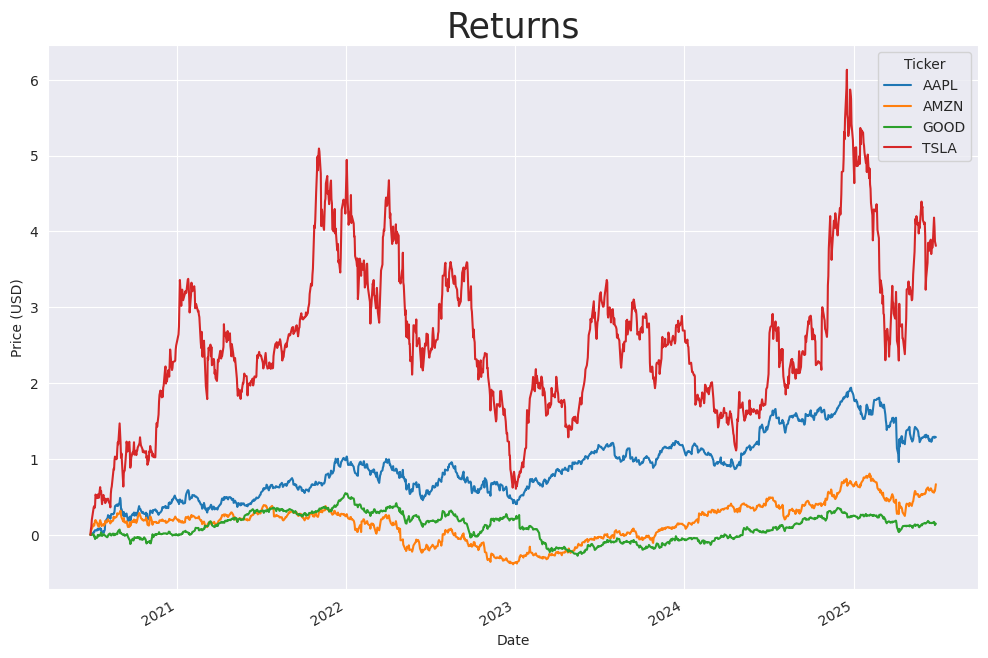

In [18]:
#Plot Cumlative Returns together
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()


In [19]:
#Create a dataframe of daily returns
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()



#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}


In [20]:
annualized_volatility

{'AAPL': np.float64(0.29734473251506616),
 'TSLA': np.float64(0.640573699288621),
 'AMZN': np.float64(0.35700511966957105),
 'GOOD': np.float64(0.2574313929595755)}

In [21]:
# Calculate the covariance matrix
covariance_matrix = 252*((daily_returns).cov())

In [22]:
covariance_matrix

Ticker,AAPL,AMZN,GOOD,TSLA
Ticker,,,,
AAPL,0.088484,0.063076,0.022343,0.095660
AMZN,0.063076,0.127554,0.021817,0.104417
GOOD,0.022343,0.021817,0.066324,0.037353
TSLA,0.095660,0.104417,0.037353,0.410662


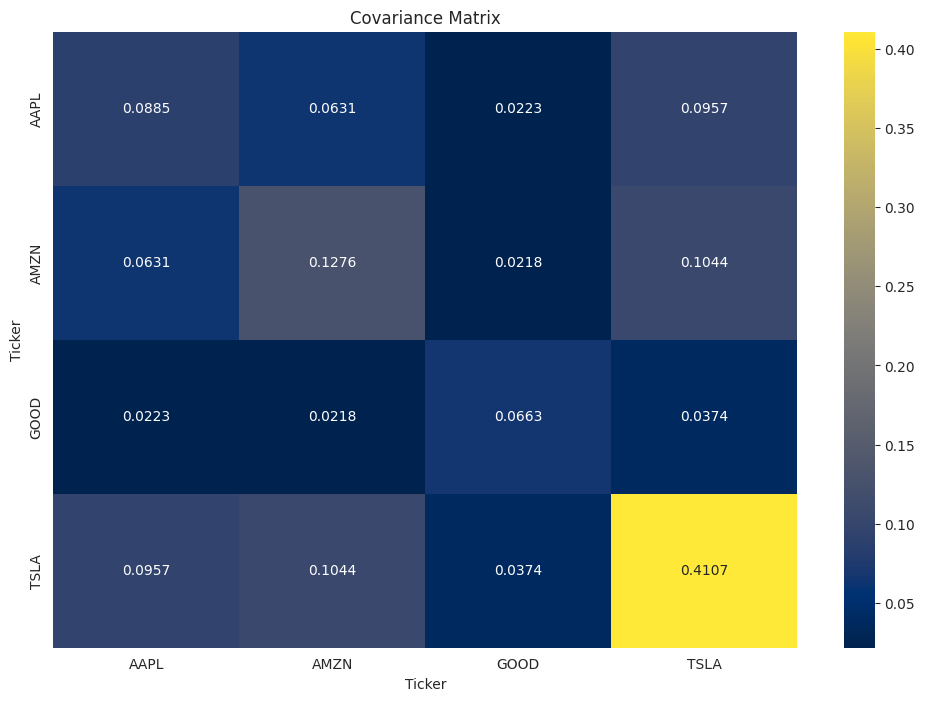

In [23]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

In [24]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols,
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Must invest at least 10% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
#expected_returns = {stock: 252*np.mean(returns[stock]) for stock in stock_symbols}


# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1
#Allocate at least 3% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.1},
              {'type': 'ineq', 'fun': lambda weights: .40-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility:
AAPL: Weight = 0.3663
TSLA: Weight = 0.1337
AMZN: Weight = 0.4000
GOOD: Weight = 0.1000


In [25]:
print(f' The optimal volatility subject to the constraints is {result.fun}')

 The optimal volatility subject to the constraints is 0.238156549961502


In [26]:
annualized_volatility

{'AAPL': np.float64(0.29734473251506616),
 'TSLA': np.float64(0.640573699288621),
 'AMZN': np.float64(0.35700511966957105),
 'GOOD': np.float64(0.2574313929595755)}

In the first portfolio we observed a volitility of $13.47\%$ and in the second portfolio we observed a volitility of $23.78\%$. Our strategy of diversifying out portfolio and navigating through different sectors in an economic cycle works.